<a href="https://colab.research.google.com/github/AiNguyen2014/MachineLearningProject/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lưu ý

# Mình sẽ đánh giá essemble của train bằng silhoutte Và đánh giá external giữa independent với actual. Internal chỉ dùng để đánh giá train thôi

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

TARGET_FOLDER = "Project Machine Learning"
BASE_PATH = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if TARGET_FOLDER in dirs:
        BASE_PATH = os.path.join(root, TARGET_FOLDER)
        break

if BASE_PATH is None:
    raise FileNotFoundError(" Không tìm thấy thư mục Project Machine Learning")

print(" Dùng thư mục:", BASE_PATH)
print(" File trong thư mục:", os.listdir(BASE_PATH))


Mounted at /content/drive
 Dùng thư mục: /content/drive/MyDrive/Project Machine Learning
 File trong thư mục: ['actual.csv', 'data_set_ALL_AML_train.csv', 'data_set_ALL_AML_independent.csv', 'train_scaled.csv', 'test_scaled.csv']


# Setup môi trường

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
from sklearn.decomposition import PCA
import joblib
warnings.filterwarnings('ignore')

# Tải dữ liệu

In [ ]:
# Train & Independent: gene là index
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_train.csv"),
    index_col=0
)

df_test = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_independent.csv"),
    index_col=0
)

# actual.csv: chỉ chứa nhãn → KHÔNG dùng index_col
df_actual = pd.read_csv(
    os.path.join(BASE_PATH, "actual.csv")
)

print("Train shape:", df_train.shape)
print("Independent shape:", df_test.shape)
print("Actual shape:", df_actual.shape)


Train shape: (7129, 77)
Independent shape: (7129, 69)
Actual shape: (72, 2)


# Tiền Xử Lý Dữ Liệu (Clean + Transpose + Z-score + PCA)

In [ ]:
# === CLEAN ===
def clean_gene_expression(df):
    drop_cols = [
        col for col in df.columns
        if "Gene Description" in col
        or "Gene Accession Number" in col
        or "call" in col.lower()
    ]
    df_clean = df.drop(columns=drop_cols, errors='ignore')
    return df_clean

# Clean
df_train_clean = clean_gene_expression(df_train)
df_test_clean  = clean_gene_expression(df_test)

# === TRANSPOSE ===
X_train = df_train_clean.T
X_test  = df_test_clean.T

print("Train shape after transpose:", X_train.shape)
print("Test shape after transpose:", X_test.shape)

# === Z-SCORE NORMALIZATION ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)

# === PCA ===
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Train PCA shape:", X_train_pca.shape)
print("Test PCA shape:", X_test_pca.shape)
print("Number of PCs kept:", pca.n_components_)

# === PCA → DataFrame ===
pc_cols = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]

X_train_pca_df = pd.DataFrame(
    X_train_pca,
    index=X_train.index,
    columns=pc_cols
)

X_test_pca_df = pd.DataFrame(
    X_test_pca,
    index=X_test.index,
    columns=pc_cols
)

# === SAVE FILE (CHỈ SỬA ĐƯỜNG DẪN) ===
X_train_out = X_train_pca_df.copy()
X_train_out.insert(0, "Sample_ID", X_train_out.index)
X_train_out.to_csv(
    os.path.join(BASE_PATH, "train_scaled.csv"),
    index=False
)

X_test_out = X_test_pca_df.copy()
X_test_out.insert(0, "Sample_ID", X_test_out.index)
X_test_out.to_csv(
    os.path.join(BASE_PATH, "test_scaled.csv"),
    index=False
)


Train shape after transpose: (38, 7129)
Test shape after transpose: (34, 7129)
Scaled train shape: (38, 7129)
Scaled test shape: (34, 7129)
Train PCA shape: (38, 32)
Test PCA shape: (34, 32)
Number of PCs kept: 32


# BASE MODELS - K-MEANS++

## Import thư viện cần thiết

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load dữ liệu đã chuẩn hóa

In [ ]:
# Đọc dữ liệu train đã được chuẩn hóa
try:
        train_path = os.path.join(BASE_PATH, 'train_scaled.csv')
        train_df = pd.read_csv(train_path)
        print(f" Đã tải dữ liệu Train từ: {train_path}")
except Exception as e:
        print(f" Lỗi tải file: {e}"); exit()

# Bỏ cột định danh không phải feature nếu tồn tại
if 'Sample_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Sample_ID'])

print(f"Kích thước dữ liệu: {train_df.shape}")
print(f"Số điểm dữ liệu: {train_df.shape[0]}")
print(f"Số chiều (features): {train_df.shape[1]}")
print("\nMẫu dữ liệu:")
print(train_df.head())

 Đã tải dữ liệu Train từ: /content/drive/MyDrive/Project Machine Learning/train_scaled.csv
Kích thước dữ liệu: (38, 32)
Số điểm dữ liệu: 38
Số chiều (features): 32

Mẫu dữ liệu:
         PC1        PC2        PC3        PC4        PC5        PC6  \
0  18.544799   5.826943 -19.442313  11.267566  -5.303304  19.100937   
1  -7.341389  10.008663  11.795698  -3.920823  13.999094 -18.636026   
2  52.852146  11.390630 -29.548566  38.800348  22.866689  -9.458113   
3  13.688551  -6.246839 -22.623318   3.982670   1.351354  13.095198   
4 -36.790106  32.799698   5.253314   2.790336   6.602306  10.731372   

         PC7        PC8        PC9       PC10  ...       PC23      PC24  \
0   9.447438   0.915309  -8.665217   7.912754  ...   5.630107 -4.538090   
1  -4.687060   8.812418   1.372678  11.690751  ... -10.669290 -5.364779   
2  22.880735  20.995112   4.038731   5.260765  ...   5.073579  0.797486   
3 -29.457761 -10.493627 -12.248064 -22.248153  ...   1.204654  8.036715   
4  -2.410778  -4.505

In [ ]:
# Chuyển đổi DataFrame sang numpy array để tính toán
X = train_df.values
print(f"\nMảng dữ liệu X có shape: {X.shape}")


Mảng dữ liệu X có shape: (38, 32)


## Định nghĩa các hàm cần dùng trong K means++

In [ ]:
"""
═══════════════════════════════════════════════════════════════════════════════
    TIỆN ÍCH: CÁC HÀM HELPER
═══════════════════════════════════════════════════════════════════════════════
Những hàm tiện ích dùng chung cho các phần khác nhau của K-means++
"""

# ═══ HÀM TIỆN ÍCH 1: TÍNH KHOẢNG CÁCH ═══
def euclidean_distance(point1, point2):
    """Tính khoảng cách Euclidean giữa hai điểm"""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def calculate_distances(X, centroids):
    """
    Tính ma trận khoảng cách từ TẤT CẢ điểm đến TẤT CẢ centroids
    Output: (n_samples, n_clusters)
    """
    n_samples = X.shape[0]
    n_clusters = centroids.shape[0]
    distances = np.zeros((n_samples, n_clusters))

    for i in range(n_samples):
        for j in range(n_clusters):
            distances[i, j] = euclidean_distance(X[i], centroids[j])

    return distances

# ═══ HÀM TIỆN ÍCH 2: TÍNH SILHOUETTE SCORE (dùng sklearn) ═══
def calculate_silhouette_score(X, labels):
    """Tính Silhouette Score bằng sklearn.metrics.silhouette_score"""
    return silhouette_score(X, labels)
print("Đã định nghĩa hàm tiện ích: khoảng cách, silhouette score (sklearn)")

"""
═══════════════════════════════════════════════════════════════════════════════
    ĐỊNH NGHĨA HÀM: BƯỚC 2, 3, 4, 5 & HÀM K-MEANS++ HOÀN CHỈNH
═══════════════════════════════════════════════════════════════════════════════
Quy trình thực thi:
  - BƯỚC 1: Đánh giá K (chạy hàm kmeans_plusplus() 9 lần với K=2-10)
  - BƯỚC 2-5: Huấn luyện với K tốt nhất (chạy hàm kmeans_plusplus() 1 lần)

Hàm này thực hiện:
  BƯỚC 2 (initialize_centroids_kmeans_plusplus): Khởi tạo K centroids
  BƯỚC 3 (assign_clusters): Gán điểm vào cụm gần nhất
  BƯỚC 4 (update_centroids): Cập nhật vị trí centroid
  BƯỚC 5 (kiểm tra hội tụ): Lặp 3→4→5 đến khi hội tụ
"""

# ═══ BƯỚC 2: KHỞI TẠO CENTROIDS (K-MEANS++) ═══
def initialize_centroids_kmeans_plusplus(X, k, random_state=None):
    """
    BƯỚC 2: Khởi tạo K centroids theo chiến lược K-MEANS++

    Tại sao? Thay vì chọn ngẫu nhiên (dễ bị kết quả xấu),
    K-means++ chọn thông minh: centroid mới cách xa các centroid đã chọn.

    Thuật toán:
    - Chọn centroid 1 ngẫu nhiên
    - Với mỗi centroid tiếp theo:
        * Tính khoảng cách từ TỪNG điểm đến centroid GẦN NHẤT
        * Chọn centroid mới với xác suất tỷ lệ với khoảng cách²
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[0]
    centroids = [X[np.random.randint(0, n_samples)]]

    for _ in range(1, k):
        distances = np.array([min([euclidean_distance(x, c) for c in centroids]) for x in X])
        probabilities = distances ** 2
        probabilities /= probabilities.sum()
        next_centroid_idx = np.random.choice(n_samples, p=probabilities)
        centroids.append(X[next_centroid_idx])

    return np.array(centroids)

# ═══ BƯỚC 3: GÁN CỤM ═══
def assign_clusters(X, centroids):
    """
    BƯỚC 3: Gán mỗi điểm dữ liệu vào cụm có centroid gần nhất
    Output: (n_samples,) - mảng nhãn cụm
    """
    distances = calculate_distances(X, centroids)
    return np.argmin(distances, axis=1)

# ═══ BƯỚC 4: CẬP NHẬT CENTROIDS ═══
def update_centroids(X, labels, k):
    """
    BƯỚC 4: Cập nhật vị trí centroid = trung bình các điểm trong cụm
    Output: (k, n_features) - các centroid mới
    """
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))

    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroids[i] = cluster_points.mean(axis=0)
        else:
            centroids[i] = X[np.random.randint(0, X.shape[0])]

    return centroids

# ═══ HÀM K-MEANS++ HOÀN CHỈNH ═══
def kmeans_plusplus(X, k, max_iters=100, tol=1e-4, random_state=None, verbose=False):
    """
    HÀM K-MEANS++ HOÀN CHỈNH

    Thực hiện toàn bộ quá trình K-means++ từ BƯỚC 2 đến BƯỚC 5:

    BƯỚC 2: Khởi tạo K centroids theo chiến lược K-means++
    BƯỚC 3: Gán các điểm vào cụm gần nhất (lặp lại)
    BƯỚC 4: Cập nhật vị trí centroids (lặp lại)
    BƯỚC 5: Kiểm tra hội tụ - nếu chưa hội tụ lặp lại bước 3-4-5

    Parameters:
    - X: (n_samples, n_features) - dữ liệu
    - k: số cụm
    - max_iters: số iterations tối đa
    - tol: ngưỡng hội tụ (tolerance)
    - random_state: seed cho tái tạo kết quả
    - verbose: in ra thông tin quá trình

    Returns:
    - labels: (n_samples,) - nhãn cụm cho mỗi điểm
    - centroids: (k, n_features) - vị trí các centroid cuối cùng
    - info: dict chứa thông tin quá trình huấn luyện
    """
    if random_state is not None:
        np.random.seed(random_state)

    # BƯỚC 2: Khởi tạo centroids
    centroids = initialize_centroids_kmeans_plusplus(X, k, random_state)

    history = {
        'iterations': 0,
        'shifts': [],
        'converged': False
    }

    for iteration in range(max_iters):
        # BƯỚC 3: Gán các điểm vào cụm
        labels = assign_clusters(X, centroids)

        # Lưu centroid cũ
        old_centroids = centroids.copy()

        # BƯỚC 4: Cập nhật centroids
        centroids = update_centroids(X, labels, k)

        # BƯỚC 5: Kiểm tra hội tụ
        centroid_shift = np.sum([euclidean_distance(old_centroids[i], centroids[i])
                                for i in range(k)])

        history['shifts'].append(centroid_shift)
        history['iterations'] = iteration + 1

        if verbose and (iteration + 1) % 10 == 0 or iteration == 0:
            print(f"  Iteration {iteration + 1}: Shift={centroid_shift:.2e}")

        if centroid_shift < tol:
            history['converged'] = True
            if verbose:
                print(f"  Hội tụ tại iteration {iteration + 1}")
            break

    return labels, centroids, history

print("Đã định nghĩa các hàm hỗ trợ (Bước 2, 3, 4, 5)")
print("  (Sẽ sử dụng ở BƯỚC 1: Đánh giá K, và BƯỚC 2-5: Huấn luyện)")



Đã định nghĩa hàm tiện ích: khoảng cách, silhouette score (sklearn)
Đã định nghĩa các hàm hỗ trợ (Bước 2, 3, 4, 5)
  (Sẽ sử dụng ở BƯỚC 1: Đánh giá K, và BƯỚC 2-5: Huấn luyện)


## BƯỚC 1: ĐÁNH GIÁ & LỰA CHỌN SỐ CỤM K TỐI ƯU
**Thực hiện:** Chạy K-means++ với K từ 2 đến 10, so sánh Silhouette Score, chọn K tốt nhất

In [ ]:
"""
═══════════════════════════════════════════════════════════════════════════════
 BƯỚC 1: ĐÁNH GIÁ - CHẠY K-MEANS++ VỚI K = 2 ĐẾN 10
═══════════════════════════════════════════════════════════════════════════════
MỤC TIÊU: Tìm K tối ưu bằng Silhouette Score
MỤC ĐÍCH: Xác định giá trị K tốt nhất trước khi huấn luyện chi tiết (Bước 2-5)
"""

print("\n" + "="*80)
print("BƯỚC 1: ĐÁNH GIÁ LỰA CHỌN SỐ CỤM K TỐI ƯU")
print("="*80)
print("\nChạy K-means++ với K từ 2 đến 10 trên dữ liệu train_scaled.csv")
print("So sánh Silhouette Score để lựa chọn K tốt nhất\n")

k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    print(f"[K={k:2d}]", end=" ")

    # Chạy K-MEANS++ với k cụm
    labels, centroids, history = kmeans_plusplus(X, k, max_iters=300, random_state=42)

    # Tính Silhouette Score
    silhouette = calculate_silhouette_score(X, labels)
    silhouette_scores.append(silhouette)

    print(f"Silhouette = {silhouette:7.4f} | Iterations = {history['iterations']}")

print("\n" + "-"*80)

# Tìm k tốt nhất
best_k_idx = np.argmax(silhouette_scores)
best_k = list(k_values)[best_k_idx]
best_silhouette = silhouette_scores[best_k_idx]

print(f"\nKẾT QUẢ ĐÁNH GIÁ:")
print(f"   K có Silhouette Score cao nhất: K = {best_k}")
print(f"   Silhouette Score: {best_silhouette:.4f}")
print(f"\n   SẼ CHỌN: K = {best_k} cho bước huấn luyện tiếp theo")
print(f"{'='*80}\n")



BƯỚC 1: ĐÁNH GIÁ LỰA CHỌN SỐ CỤM K TỐI ƯU

Chạy K-means++ với K từ 2 đến 10 trên dữ liệu train_scaled.csv
So sánh Silhouette Score để lựa chọn K tốt nhất

[K= 2]   Iteration 1: Shift=1.66e+02
Silhouette =  0.1985 | Iterations = 2
[K= 3]   Iteration 1: Shift=2.39e+02
Silhouette =  0.1053 | Iterations = 2
[K= 4]   Iteration 1: Shift=3.17e+02
Silhouette =  0.0554 | Iterations = 2
[K= 5]   Iteration 1: Shift=3.73e+02
Silhouette =  0.0321 | Iterations = 2
[K= 6]   Iteration 1: Shift=3.70e+02
Silhouette =  0.0350 | Iterations = 2
[K= 7]   Iteration 1: Shift=2.32e+02
Silhouette =  0.0767 | Iterations = 2
[K= 8]   Iteration 1: Shift=2.77e+02
Silhouette =  0.0728 | Iterations = 3
[K= 9]   Iteration 1: Shift=3.27e+02
Silhouette =  0.0403 | Iterations = 3
[K=10]   Iteration 1: Shift=3.80e+02
Silhouette =  0.0476 | Iterations = 3

--------------------------------------------------------------------------------

KẾT QUẢ ĐÁNH GIÁ:
   K có Silhouette Score cao nhất: K = 2
   Silhouette Score: 0.1985

In [ ]:
"""
═══════════════════════════════════════════════════════════════════════════════
    BƯỚC 2-5: HUẤN LUYỆN MÔ HÌNH K-MEANS++ CHI TIẾT
═══════════════════════════════════════════════════════════════════════════════
MỤC TIÊU: Sử dụng K tốt nhất từ BƯỚC 1 để huấn luyện mô hình chi tiết
MỤC ĐÍCH: Theo dõi từng iteration - gán → cập nhật → kiểm tra hội tụ
"""

print("\n" + "="*80)
print("BƯỚC 2-5: HUẤN LUYỆN MÔ HÌNH K-MEANS++ CHI TIẾT")
print("="*80)
print(f"\nSỐ CỤM ĐƯỢC CHỌN: K = {best_k}")
print(f"  (Dựa trên Silhouette Score cao nhất = {best_silhouette:.4f})\n")

# Chạy K-means với K tốt nhất, verbose để thấy quá trình
print(f"{'─'*80}")
print("Chạy K-means++ với K = {} trên dữ liệu train_scaled.csv".format(best_k))
print(f"{'─'*80}\n")

labels_final, centroids_final, training_history = kmeans_plusplus(
    X, best_k, max_iters=100, tol=1e-4, random_state=42, verbose=True
)

print(f"\n{'─'*80}")
if training_history['converged']:
    print(f"THUẬT TOÁN HỘI TỤ sau {training_history['iterations']} iterations")
else:
    print(f"ĐẠT SỐ ITERATIONS TỐI ĐA ({training_history['iterations']})")
print(f"{'─'*80}\n")

# Lưu lịch sử
history_centroid_shifts = training_history['shifts']
iteration_count = training_history['iterations']



BƯỚC 2-5: HUẤN LUYỆN MÔ HÌNH K-MEANS++ CHI TIẾT

SỐ CỤM ĐƯỢC CHỌN: K = 2
  (Dựa trên Silhouette Score cao nhất = 0.1985)

────────────────────────────────────────────────────────────────────────────────
Chạy K-means++ với K = 2 trên dữ liệu train_scaled.csv
────────────────────────────────────────────────────────────────────────────────

  Iteration 1: Shift=1.66e+02
  Hội tụ tại iteration 2

────────────────────────────────────────────────────────────────────────────────
THUẬT TOÁN HỘI TỤ sau 2 iterations
────────────────────────────────────────────────────────────────────────────────



## ĐÁNH GIÁ KẾT QUẢ MÔ HÌNH TRÊN DỮ LIỆU TRAIN

In [ ]:
print("\n" + "="*80)
print("THỐNG KÊ CHI TIẾT VỀ KẾT QUẢ HỌC")
print("="*80)

# Tính chỉ số cuối cùng
final_silhouette = calculate_silhouette_score(X, labels_final)

print(f"\nTHÔNG TIN CHUNG:")
print(f"   - Dữ liệu: train_scaled.csv")
print(f"   - Số mẫu (samples): {X.shape[0]}")
print(f"   - Số features: {X.shape[1]}")
print(f"   - Số cụm (K): {best_k}")

print(f"\nCHỈ SỐ ĐÁNH GIÁ:")
print(f"   - Silhouette Score: {final_silhouette:.4f}")

print(f"\nTHÔNG TIN HỌC:")
print(f"   - Số iterations: {iteration_count}")
print(f"   - Trạng thái: {'Hội tụ' if training_history['converged'] else 'Max iterations'}")

print(f"\nPHÂN BỐ CÁC CỤM:")
for cluster_id in range(best_k):
    count = np.sum(labels_final == cluster_id)
    percentage = (count / len(labels_final)) * 100
    print(f"   - Cụm {cluster_id}: {count:4d} điểm ({percentage:5.1f}%)")

print(f"\nTHÔNG TIN CENTROIDS:")
for i, centroid in enumerate(centroids_final):
    print(f"   Centroid {i}:")
    print(f"     - Giá trị trung bình: {centroid.mean():.4f}")
    print(f"     - Độ lệch chuẩn: {centroid.std():.4f}")
    print(f"     - Range: [{centroid.min():.4f}, {centroid.max():.4f}]")

print(f"\n{'='*80}\n")



THỐNG KÊ CHI TIẾT VỀ KẾT QUẢ HỌC

THÔNG TIN CHUNG:
   - Dữ liệu: train_scaled.csv
   - Số mẫu (samples): 38
   - Số features: 32
   - Số cụm (K): 2

CHỈ SỐ ĐÁNH GIÁ:
   - Silhouette Score: 0.1985

THÔNG TIN HỌC:
   - Số iterations: 2
   - Trạng thái: Hội tụ

PHÂN BỐ CÁC CỤM:
   - Cụm 0:   34 điểm ( 89.5%)
   - Cụm 1:    4 điểm ( 10.5%)

THÔNG TIN CENTROIDS:
   Centroid 0:
     - Giá trị trung bình: -0.1967
     - Độ lệch chuẩn: 1.4522
     - Range: [-7.5357, 1.2901]
   Centroid 1:
     - Giá trị trung bình: 1.6716
     - Độ lệch chuẩn: 12.3436
     - Range: [-10.9656, 64.0538]




# BASE MODELS - HIERARCHICAL

# **Xây dựng mô hình (Training) và đánh giá nội bộ (chưa đụng đến tập Test hay so sánh với thực tế)**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import os

# ============================================================
# PHẦN 1: BASE LEARNER - HIERARCHICAL CLUSTERING
# ============================================================

class HierarchicalClustering:
    def __init__(self, n_clusters=2, linkage='ward'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _compute_distance_matrix(self, X):
        n = X.shape[0]
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                dist = self._euclidean_distance(X[i], X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

    # --- Linkage Functions ---
    def _single_linkage(self, c1_idxs, c2_idxs, dist_matrix):
        min_dist = float('inf')
        for i in c1_idxs:
            for j in c2_idxs:
                if dist_matrix[i, j] < min_dist: min_dist = dist_matrix[i, j]
        return min_dist

    def _complete_linkage(self, c1_idxs, c2_idxs, dist_matrix):
        max_dist = 0
        for i in c1_idxs:
            for j in c2_idxs:
                if dist_matrix[i, j] > max_dist: max_dist = dist_matrix[i, j]
        return max_dist

    def _ward_linkage(self, c1_idxs, c2_idxs, X):
        m1 = np.mean(X[c1_idxs], axis=0)
        m2 = np.mean(X[c2_idxs], axis=0)
        n1, n2 = len(c1_idxs), len(c2_idxs)
        return np.sqrt((2 * n1 * n2) / (n1 + n2)) * self._euclidean_distance(m1, m2)

    def _cluster_distance(self, c1_idxs, c2_idxs, dist_matrix, X):
        if self.linkage == 'single': return self._single_linkage(c1_idxs, c2_idxs, dist_matrix)
        elif self.linkage == 'complete': return self._complete_linkage(c1_idxs, c2_idxs, dist_matrix)
        elif self.linkage == 'ward': return self._ward_linkage(c1_idxs, c2_idxs, X)

    def fit(self, X):
        n_samples = X.shape[0]
        clusters = {i: [i] for i in range(n_samples)}

        dist_matrix = None
        if self.linkage != 'ward':
            dist_matrix = self._compute_distance_matrix(X)

        while len(clusters) > self.n_clusters:
            min_dist = float('inf')
            merge_pair = None
            ids = list(clusters.keys())

            # Tìm cặp gần nhất
            for i in range(len(ids)):
                for j in range(i+1, len(ids)):
                    id1, id2 = ids[i], ids[j]
                    dist = self._cluster_distance(clusters[id1], clusters[id2], dist_matrix, X)
                    if dist < min_dist:
                        min_dist = dist
                        merge_pair = (id1, id2)

            # Gộp
            c1, c2 = merge_pair
            new_id = max(ids) + 1
            clusters[new_id] = clusters[c1] + clusters[c2]
            del clusters[c1]; del clusters[c2]

        # Lưu nhãn cuối cùng
        self.labels_ = np.zeros(n_samples, dtype=int)
        for idx, (cid, members) in enumerate(clusters.items()):
            self.labels_[members] = idx
        return self

# ============================================================
# PHẦN 2: CHUẨN BỊ CHO ENSEMBLE (BASE LEARNERS)
# ============================================================

if __name__ == "__main__":
    # 1. Load Data
    try:
        train_path = os.path.join(BASE_PATH, 'train_scaled.csv')
        train_df = pd.read_csv(train_path)
        X_train = train_df.drop('Sample_ID', axis=1, errors='ignore').values
        print(f" Đã tải dữ liệu: {X_train.shape}")
    except Exception as e:
        print(f"Lỗi: {e}"); exit()

    # 2. Tạo tập hợp các Base Learners (Đa dạng hóa bằng Linkage)
    # Lưu ý quan trọng: n_clusters=2 (Chuẩn bài toán ung thư)
    linkages = ['single', 'complete', 'ward']
    base_models = {}

    print("\n ĐANG XÂY DỰNG CÁC BASE LEARNERS...")

    for link in linkages:
        print(f"   -> Training {link.upper()} model...")
        model = HierarchicalClustering(n_clusters=2, linkage=link)
        model.fit(X_train)

        # Lưu model vào dictionary để dùng cho Ensemble sau này
        base_models[link] = model

        # Đánh giá nhanh chất lượng từng model con
        sil = silhouette_score(X_train, model.labels_)
        print(f"      (Silhouette: {sil:.4f})")

    print(f"\n Đã chuẩn bị xong {len(base_models)} mô hình cơ sở cho Ensemble!")
    print(f"   Danh sách: {list(base_models.keys())}")

 Đã tải dữ liệu: (38, 32)

 ĐANG XÂY DỰNG CÁC BASE LEARNERS...
   -> Training SINGLE model...
      (Silhouette: 0.2811)
   -> Training COMPLETE model...
      (Silhouette: 0.2846)
   -> Training WARD model...
      (Silhouette: 0.0977)

 Đã chuẩn bị xong 3 mô hình cơ sở cho Ensemble!
   Danh sách: ['single', 'complete', 'ward']


# BASE MODELS - GMM

Train shape: (38, 32)
Independent shape: (34, 32)
Train cluster labels: [0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0
 0]
Independent cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Silhouette score (TRAIN): 0.0422


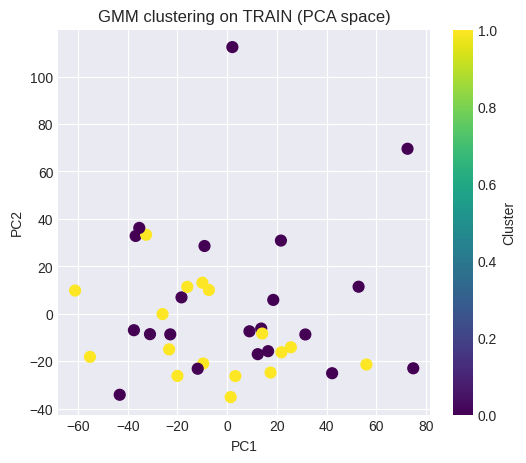

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load data sau PCA
train_df = pd.read_csv(os.path.join(BASE_PATH, "train_scaled.csv"))
test_df  = pd.read_csv(os.path.join(BASE_PATH, "test_scaled.csv"))

X_train = train_df.drop(columns=["Sample_ID"], errors="ignore").values
X_test  = test_df.drop(columns=["Sample_ID"], errors="ignore").values

print("Train shape:", X_train.shape)
print("Independent shape:", X_test.shape)

class GMM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol

    def gaussian(self, X, mean, cov):
        d = X.shape[1]
        cov += np.eye(d) * 1e-6
        inv = np.linalg.inv(cov)
        det = np.linalg.det(cov)
        diff = X - mean
        expo = np.sum(diff @ inv * diff, axis=1)
        coef = 1.0 / np.sqrt((2*np.pi)**d * det)
        return coef * np.exp(-0.5 * expo)

    def fit(self, X):
        n, d = X.shape
        rng = np.random.default_rng(42)

        self.means = X[rng.choice(n, self.K, replace=False)]
        self.covs = np.array([np.cov(X.T) for _ in range(self.K)])
        self.weights = np.ones(self.K) / self.K

        prev_ll = None

        for _ in range(self.max_iter):
            resp = np.zeros((n, self.K))

            # E-step
            for k in range(self.K):
                resp[:, k] = self.weights[k] * self.gaussian(X, self.means[k], self.covs[k])

            resp_sum = resp.sum(axis=1, keepdims=True)
            resp /= resp_sum

            Nk = resp.sum(axis=0)

            # M-step
            for k in range(self.K):
                self.means[k] = np.sum(resp[:, k][:, None] * X, axis=0) / Nk[k]
                diff = X - self.means[k]
                self.covs[k] = (resp[:, k][:, None] * diff).T @ diff / Nk[k]
                self.weights[k] = Nk[k] / n

            ll = np.sum(np.log(resp_sum))
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

    def predict(self, X):
        probs = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            probs[:, k] = self.weights[k] * self.gaussian(X, self.means[k], self.covs[k])
        return np.argmax(probs, axis=1)

# Train GMM
gmm = GMM(n_components=2)
gmm.fit(X_train)

train_labels = gmm.predict(X_train)
test_labels  = gmm.predict(X_test)

print("Train cluster labels:", train_labels)
print("Independent cluster labels:", test_labels)

# Silhouette tự tính (internal – TRAIN ONLY)
def silhouette_manual(X, labels):
    n = X.shape[0]
    dist = np.linalg.norm(X[:, None] - X[None, :], axis=2)
    sil = []
    for i in range(n):
        same = labels == labels[i]
        other = labels != labels[i]
        a = np.mean(dist[i, same]) if np.sum(same) > 1 else 0
        b = min(np.mean(dist[i, labels == l]) for l in np.unique(labels) if l != labels[i])
        sil.append((b - a) / max(a, b))
    return np.mean(sil)

sil_score = silhouette_manual(X_train, train_labels)
print("Silhouette score (TRAIN):", round(sil_score, 4))

# Trực quan PCA 2D (TRAIN)
X_vis = X_train[:, :2]
plt.figure(figsize=(6,5))
plt.scatter(X_vis[:,0], X_vis[:,1], c=train_labels, cmap="viridis", s=60)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("GMM clustering on TRAIN (PCA space)")
plt.colorbar(label="Cluster")
plt.show()

# Output cho ensemble
gmm_labels_train = train_labels
gmm_labels_test  = test_labels


# ENSEMBLE CLUSTERING

#  TEST ON INDEPENDENT

#  EVALUATION